In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install necessary packages
!pip install tf_fourier_features
!pip install geomdl

In [ ]:
# import standard packages
from __future__ import division
from numpy import *
import numpy as np
from scipy.sparse import coo_matrix
from matplotlib import colors
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import time
import os
import gc
import warnings


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# path of current folder
folder_path = '/content/drive/MyDrive/DEM_TO/Compliant_Gripper/'
# add the path to python's search list
sys.path.append(folder_path)
sys.path.append(folder_path+'/UtilityFunctions')

In [ ]:
# import custimized modules
import utils as ut
import surrogate_model_primal as sm_pr
import surrogate_model_adjoint as sm_ad
from mma import mmasub

In [ ]:
# use gpu for tensorflow
if tf.config.list_physical_devices('GPU'):
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('Using GPU')
else:
  print('Using CPU')

Using GPU


In [ ]:
ut.makepath(folder_path+'TOdesign')
ut.makepath(folder_path+'surrogate_result')
ut.makepath(folder_path+'model_pr')
ut.makepath(folder_path+'model_ad')

'/content/drive/MyDrive/DEM_TO/Compliant_Gripper/model_ad/'

In [ ]:
class TO2D_CMGripper():
    def __init__(self,Lx=120,Ly=60,nelx=120,nely=60,volfrac=0.3,rmin=4.2,maxiter=1000,filter=0,x_init=0.3,pv=None,ps=None):
        self.Lx = Lx
        self.Ly = Ly
        self.nelx = nelx
        self.nely = nely
        self.volfrac = volfrac
        self.rmin = rmin
        self.maxiter = maxiter
        self.ft = filter
        self.x_init = x_init* np.ones(self.nely*self.nelx,dtype=float)
        self.passive_void = pv
        self.passive_solid = ps
        self.x_init[np.where(self.passive_void==1)] = 0.
        self.x_init[np.where(self.passive_solid==1)] = 1.
        print("2D TO for CM Gripper")
        print("Number of nodes: " + str(self.nelx) + " x " + str(self.nely))
        print("Volume fraction: " + str(self.volfrac) + ", rmin: " + str(self.rmin))
        print("Filter method: " + ["Density based","Density based + Heaviside filter"][self.ft])

    def optimize(self):
        x = self.x_init.copy()

        nn = len(x)
        mm = 1
        [geps,xval,move,xmin,xmax,fmax,mma_a,mma_c] = self.mmaInit(mm, nn, self.volfrac)
        xlow = xmin
        xupp = xmax
        xold1 = xval
        xold2 = xval

        Hbeta = 1
        if self.ft==0:
            xPhys=x.copy()
        elif self.ft==1:
            xTilde=x.copy()
            xPhys=1-np.exp(-Hbeta*xTilde)+xTilde*np.exp(-Hbeta)

        H,Hs = ut.DensityFilter_init(self.rmin,self.nelx,self.nely)

        Nsample = 40000

        Xint, Wint, _, _, eleidx = ut.getquadpts(L=self.Lx,H=self.Ly,Nelmufem=self.nelx,Nelmvfem=self.nely,numElemU=self.nelx,numElemV=self.nely,numGauss=2,bdcode=1)
        input_dof,evenidx,oddidx = ut.generatedofcoord(nelx=self.nelx,nely=self.nely,L=self.Lx,H=self.Ly)
        Wint = np.squeeze(Wint)

        rhoden = np.ones_like(Xint[:,0:1])*0.3

        mesh = {'nelx':self.nelx,'nely':self.nely,'L':self.Lx,'H':self.Ly,\
        'eleidx':eleidx,'Xint':Xint,'input_dof':input_dof,'evenidx':evenidx,'oddidx':oddidx,\
                'X_densified':Xint,'rho_densified':rhoden,'Nsample':Nsample}

        E=1
        Emin=1e-3
        nu=0.3
        k1=1
        k2=0.001
        p=3
        material = {'volfrac':self.volfrac,'E':E,'Emin':Emin,'nu':nu,'p':p,'k1':k1,'k2':k2,\
                    'lambda':1*nu/((1 + nu)*(1 - nu)),'mu':1/(2*(1 + nu))}

        lr = 1e-3
        Nepoch = 10
        batch_size = 2000
        neuron = 86
        rff_dev = 1.32
        N_Layers = 4
        act_func = 'swish'
        N_input_rho = self.nelx*self.nely
        N_input_coord = 2
        trainParams={'lr':lr,'Nepoch':Nepoch,'Nbatch':batch_size,'Nneuron':neuron,'rff_dev':rff_dev,'Nlayers':N_Layers,'activation':act_func,'N_input_rho':N_input_rho,'N_input_coord':N_input_coord}

        self.SModel_pr = sm_pr.SurrogateModel_primal()
        self.SModel_pr.updatemesh(mesh)
        self.SModel_pr.updatematerial(material)
        self.SModel_pr.updatetrainParams(trainParams)

        self.SModel_ad = sm_ad.SurrogateModel_adjoint()
        self.SModel_ad.updatemesh(mesh)
        self.SModel_ad.updatematerial(material)
        self.SModel_ad.updatetrainParams(trainParams)

        transfer = tf.keras.models.Sequential([
        tf.keras.layers.ZeroPadding2D(padding=(1, 1), input_shape=(self.nelx, self.nely, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=1),])

        dof_coord = np.repeat(input_dof,2,axis=0)
        input_dof_DBC1 = np.zeros((1000,2))
        input_dof_DBC1[:,0] = 0.
        input_dof_DBC1[:,1] = np.linspace(0,self.Ly/30,1000)
        input_dof_DBC2 = np.zeros((1000,2))
        input_dof_DBC2[:,1] = self.Ly
        input_dof_DBC2[:,0] = np.linspace(0,self.Lx,1000)

        loop=0
        iter=0
        change=1
        dv = np.ones(self.nely*self.nelx)
        dc = np.ones(self.nely*self.nelx)
        start_time=time.time()

        while change>-1 and loop<=self.maxiter:
            loop=loop+1
            iter += 1

            x_res = xPhys.reshape((1,self.nelx,self.nely,1))
            x_res = np.array(transfer(x_res)).flatten()

            rhoden = xPhys[eleidx]

            data = {'rho':xPhys,'rho_quad':x_res,'DBC1':input_dof_DBC1,'DBC2':input_dof_DBC2,'rho_densified':rhoden}

            if loop==1:
              trainParams={'lr':lr,'Nepoch':200,'Nbatch':batch_size,'Nneuron':neuron,'rff_dev':rff_dev,'Nlayers':N_Layers,'activation':act_func,'N_input_rho':N_input_rho,'N_input_coord':N_input_coord}
            else:
              trainParams={'lr':lr,'Nepoch':Nepoch,'Nbatch':batch_size,'Nneuron':neuron,'rff_dev':rff_dev,'Nlayers':N_Layers,'activation':act_func,'N_input_rho':N_input_rho,'N_input_coord':N_input_coord}
            self.SModel_pr.updatetrainParams(trainParams)
            self.SModel_ad.updatetrainParams(trainParams)

            self.SModel_pr.updatetrainset(data)
            self.SModel_ad.updatetrainset(data)
            if loop==1:
                self.SModel_pr.initialize_model()
                self.SModel_ad.initialize_model()

            self.SModel_pr.trainmodel(verbose=True)
            print('Train ends after %d epochs'%self.SModel_pr.Endepoch)
            if loop%1==0:
                self.SModel_pr.Model.save(folder_path+'model_pr/model_pr.h5')

            self.SModel_ad.trainmodel(verbose=True)
            print('Train ends after %d epochs'%self.SModel_ad.Endepoch)
            if loop%1==0:
                self.SModel_ad.Model.save(folder_path+'model_ad/model_ad.h5')

            u = np.ones(((self.nelx+1)*(self.nely+1)*2,1))
            U,V = self.SModel_pr.Model.predict(input_dof)
            u[evenidx,0]=np.squeeze(U)
            u[oddidx,0]=np.squeeze(V)

            lm = np.ones(((self.nelx+1)*(self.nely+1)*2,1))
            lm_x,lm_y = self.SModel_ad.Model.predict(input_dof)
            lm[evenidx,0]=np.squeeze(lm_x)
            lm[oddidx,0]=np.squeeze(lm_y)

            if loop%1==0:
                ut.plotdesign(folder_path+'surrogate_result/','current_design',xPhys,nelx=self.nelx,nely=self.nely)
                ut.plotresult_contour(folder_path+'surrogate_result/','solution_U',input_dof,U,L=self.Lx,H=self.Ly)
                ut.plotresult_contour(folder_path+'surrogate_result/','solution_V',input_dof,V,L=self.Lx,H=self.Ly)
                ut.plotresult_contour(folder_path+'surrogate_result/','solution_lambda_x',input_dof,lm_x,L=self.Lx,H=self.Ly)
                ut.plotresult_contour(folder_path+'surrogate_result/','solution_lambda_y',input_dof,lm_y,L=self.Lx,H=self.Ly)

            volume = np.sum(xPhys)/(self.nelx*self.nely)
            dv = np.ones(self.nely*self.nelx)/self.nelx/self.nely

            cost = -1*u[self.nelx*(self.nely+1)*2+2*self.nelx//5+1][0]
            psi_x_dx,psi_x_dy,psi_y_dx,psi_y_dy = self.SModel_ad.nabla_psi(ut.preprocess(Xint[:,0]),ut.preprocess(Xint[:,1]))
            sig_hat_xx,sig_hat_xy,sig_hat_yy = self.SModel_pr.sigma_hat(ut.preprocess(Xint[:,0]),ut.preprocess(Xint[:,1]))
            F_GQ = psi_x_dx*sig_hat_xx + psi_x_dy*sig_hat_xy+ psi_y_dx*sig_hat_xy+ psi_y_dy*sig_hat_yy
            FW = F_GQ*Wint
            FW = np.reshape(FW,(-1,4))
            dc_hat = np.sum(FW,axis=1)
            dc_hat1 = dc_hat.copy()
            dc_hat1[:][eleidx[0::4]] = dc_hat
            dc = -(3*xPhys**(3-1)*(E-Emin))*dc_hat1

            if self.ft==0:
                dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
                dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]
            elif self.ft==1:
                dx = Hbeta*np.exp(-Hbeta*xTilde)+np.exp(-Hbeta)
                dc[:] = np.asarray(H*((dc*dx)[np.newaxis].T/Hs))[:,0]
                dv[:] = np.asarray(H*((dv*dx)[np.newaxis].T/Hs))[:,0]

            xold2 = xold1.copy()
            xold1 = x.copy()
            g = volume/self.volfrac
            dg = dv/self.volfrac

            xmin = maximum(zeros([nn,]), xval-move)
            xmax = minimum(ones([nn,]), xval+move)
            [iyfree,xmma,xlow,xupp,alfa,beta,mma_b,mma_y,mma_z,ulam,mma_p,mma_q,p0,q0,uu,gradf,dsrch,hessf] = \
                mmasub(iter,mm,nn,geps,xval,
                    xmin, xmax, xold1,xold2,xlow,xupp,
                    mma_a,mma_c,cost,g,fmax,dc, dg)
            xmma[np.where(self.passive_void==1)]=0.
            xmma[np.where(self.passive_solid==1)]=1.
            xold2 = xold1
            xold1 = xval
            xval = xmma
            x[:] = xmma

            if self.ft==0:	xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
            elif self.ft==1:
                xTilde[:] = np.asarray(H*x[np.newaxis].T/Hs)[:,0]
                xPhys[:] = 1-np.exp(-Hbeta*xTilde)+xTilde*np.exp(-Hbeta)
            change=np.abs(xmma-xold1).max()

            if self.ft==1 and Hbeta<512 and loopbeta >=50:# or change<=0.01):
                Hbeta = 2*Hbeta
                loopbeta = 0
                change = 1
                print('Parameter beta increased to %d.\n'%Hbeta)

            if loop>1:
                del fig, ax
            fig,ax = plt.subplots()
            im = ax.imshow(xPhys.reshape((self.nelx,self.nely)).T, cmap='gray_r',\
            interpolation='none',norm=colors.Normalize(vmin=0,vmax=1))
            fig.show()
            fig.canvas.draw()

            if loop%1==0:
                plt.savefig(folder_path+'TOdesign/design%d.png'%(loop))
                plt.close('all')
                np.savetxt(folder_path+'TOdesign/design%d.txt'%(loop),xPhys)

            print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
                        loop,cost,volume,change))

            gc.collect()

        end_time=time.time()-start_time
        print('total time is: ', end_time)
        plt.show()

    def mmaInit(self, m, n, volfrac):
        move = 0.5 # move limit
        geps = 1e-9  # 1e-7

        xmin = zeros([n,]) # 0.001*ones([3,])
        xmax= ones([n,])
        # xval = volfrac*ones([n,])
        xval = ones([n,])*self.x_init

        # vol/volfrac < 1 where RHS is fmax
        fmax = 1.*ones([m,])

        mma_a = 0.*ones([m,])
        mma_c = 1000.*ones([m,])

        return geps,xval,move, xmin,xmax,fmax,mma_a,mma_c


    def __call__(self):
        self.optimize()




2D TO for CM Gripper
Number of nodes: 120 x 60
Volume fraction: 0.3, rmin: 4.2
Filter method: Density based
Epoch 50:
lr: 1.00e-03
Data=2.6083e-05,               PDE=-4.9823e-01,               total_loss=-4.9821e-01
Epoch 100:
lr: 1.00e-03
Data=2.6285e-05,               PDE=-4.9845e-01,               total_loss=-4.9843e-01
Epoch 150:
lr: 1.00e-03
Data=1.8476e-05,               PDE=-4.9875e-01,               total_loss=-4.9873e-01
Epoch 200:
lr: 1.00e-03
Data=1.2844e-05,               PDE=-4.9882e-01,               total_loss=-4.9881e-01
Train ends after 200 epochs
Epoch 50:
lr: 1.00e-03
Data=5.7156e-03,               PDE=-5.9197e+01,               total_loss=-5.9192e+01
Epoch 100:
lr: 1.00e-03
Data=3.7540e-03,               PDE=-5.9503e+01,               total_loss=-5.9499e+01
Epoch 150:
lr: 1.00e-03
Data=2.9561e-03,               PDE=-6.0200e+01,               total_loss=-6.0197e+01
Epoch 200:
lr: 1.00e-03
Data=3.9590e-03,               PDE=-6.0832e+01,               total_loss=-6.082

KeyboardInterrupt: 

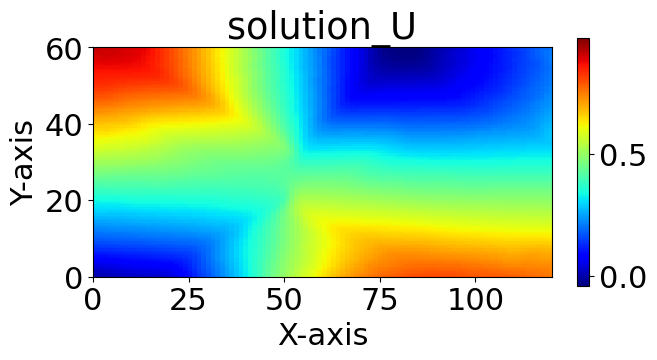

In [ ]:
volfrac = 0.3
nelx = 120
nely = 60
Lx=120
Ly=60

passive_void = np.zeros((nelx,nely))
passive_solid = np.zeros((nelx,nely))
x_c = np.linspace(Lx/nelx/2,Lx-Lx/nelx/2,nelx)
y_c = np.linspace(Ly-Ly/nely/2,Ly/nely/2,nely)
for ely in range(nely):
    for elx in range(nelx):
        if x_c[elx]>(Lx-Lx/5) and y_c[ely]>(Ly-Lx/5):
            passive_void[elx,ely] = 1
        if x_c[elx]>(Lx-Lx/5) and y_c[ely]<(Ly-Lx/5) and y_c[ely]>(Ly-Lx/5-Lx/20):
            passive_solid[elx,ely] = 1

passive_void = passive_void.flatten()
passive_solid = passive_solid.flatten()

to2d = TO2D_CMGripper(Lx=120,Ly=60,nelx=nelx,nely=nely,filter=0,rmin=4.2*Lx/nelx,volfrac=volfrac,x_init=volfrac,pv=passive_void,ps = passive_solid)
to2d.optimize()